## Preambule

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pth
import xarray as xr
from plotly.subplots import make_subplots
from tqdm import tqdm
import plotly.graph_objects as go
from pathlib import Path
import yaml
from scipy.stats import norm
import matplotlib.mlab as mlab

## Read

In [98]:
with open("../Configuration/config.yaml", "r") as stream:
    settings = yaml.load(stream, Loader=yaml.Loader)
integers_touse = [0, 1, 3, 4, 5, 7, 8, 9]
list_of_models = np.array([settings['models'][m]['full_name'] for m in settings['models'].keys()])[integers_touse]
list_of_model_shortnames = np.array([settings['models'][m]['short_name'] for m in settings['models'].keys()])[integers_touse]
list_of_colors = np.array([settings['models'][m]['color'] for m in settings['models'].keys()])[integers_touse]
ind_xr = xr.open_dataset(settings['paths']['data']['output']+"XRindicators.nc").sel(Model=list_of_models, Region='Europe')
data_xr = xr.open_dataset(settings['paths']['data']['handling']+"XRdata.nc").sel(Model=list_of_models, Region='Europe')

## Check coverage

In [99]:
ar = np.array(data_xr.sel(Variable="Emissions|CO2", Time=2050, Scenario=settings['scenarios_c400']+['DIAG-NPI']).Value).flatten()
print("Fraction model-scenario coverage:", len(np.where(~np.isnan(ar))[0])/len(ar))

Fraction model-scenario coverage: 0.8875


## Now specify to only the c400 scenarios

In [100]:
ind_xr = xr.open_dataset(settings['paths']['data']['output']+"XRindicators.nc").sel(Scenario=settings['scenarios_c400'], Model=list_of_models, Region='Europe')
data_xr = xr.open_dataset(settings['paths']['data']['handling']+"XRdata.nc").sel(Scenario=settings['scenarios_c400'], Model=list_of_models, Region='Europe')

## Correlation R2 and R3

In [101]:
r2 = np.array(ind_xr.sel(Indicator='R2_time', Time=2050).Value).flatten()
r3 = np.array(ind_xr.sel(Indicator='R3_speedmax',Time=2050).Value).flatten()
nonans = np.intersect1d(np.where(~np.isnan(r2))[0], np.where(~np.isnan(r3))[0])
r2 = r2[nonans]
r3 = r3[nonans]
print(np.corrcoef(r2, r3)[0][1])

-0.5905100893931501


## Table + Histogram for statistics

Median    : 0.0
Range min : -0.0
Range max : 0.0
Index disp: 0.0
max dev   : 5.99


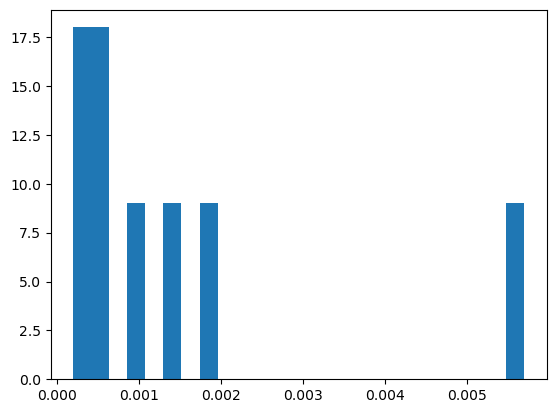

In [102]:
var = "R4_sensprim"
dat = np.array(ind_xr.sel(Indicator=var, Time=2050).Value).flatten()
dat[dat == 0] = np.nan
print("Median    :", np.nanmedian(dat).round(2))
print("Range min :", (np.nanmedian(dat)-2*np.nanstd(dat)).round(2))
print("Range max :", (np.nanmedian(dat)+2*np.nanstd(dat)).round(2))
print("Index disp:", np.abs((np.nanstd(dat)**2/np.nanmean(dat)).round(2)))
print("max dev   :", (np.nanmax(np.abs(dat - np.nanmedian(dat))/np.nanmedian(dat))).round(2))
plt.hist(dat, 25)
plt.show()
rows = []
for var in list(np.array(ind_xr.Indicator)):
    dat = np.array(ind_xr.sel(Indicator=var, Time=2050).Value).flatten()
    dat[dat == 0] = np.nan
    if var == "C1_cost" or var == "R5_sensdem":
        dat = dat*1e3
    if var == 'R4_sensprim': rnd = 3
    else: rnd = 2
    rows.append([var, np.nanmedian(dat).round(rnd), (np.nanmedian(dat)-2*np.nanstd(dat)).round(rnd), (np.nanmedian(dat)+2*np.nanstd(dat)).round(rnd), np.abs(np.nanstd(dat)/np.nanmean(dat)).round(rnd), (np.nanmax(np.abs(dat - np.nanmedian(dat))/np.nanmedian(dat))).round(rnd)])
df = pd.DataFrame(rows, columns=["Indicator", "Median", "Range_min", "Range_max", "Index_disp", "Max_dev"])
df.to_csv(settings['paths']['data']['output'] + "Indicators_statistics.csv")

## Plot

#### GDP comparison

In [103]:
# av_gdp = np.array(readclass.pd_mod[readclass.pd_mod.Variable == 'GDP|PPP'])[:, 5:]
# time = readclass.pd_mod.keys()[5:].astype(int)
# mods_gdp = []
# av_gdp_permodel = {}
# for m_i, m in enumerate(readclass.list_of_models):
#     try:
#         ag = (np.array(readclass.pd_mod[(readclass.pd_mod.Variable == 'GDP|PPP') & (readclass.pd_mod.Model == m) & (readclass.pd_mod.Region == 'Europe')])[:, 5:]).mean(axis=0)
#         if np.nansum(ag) > 0:
#             av_gdp_permodel[m] = ag
#             mods_gdp.append(m)
#     except:
#         continue
# for m in mods_gdp:
#     plt.plot(time, av_gdp_permodel[m],label=m)
# plt.legend()

#### Plot on S2 vs S3

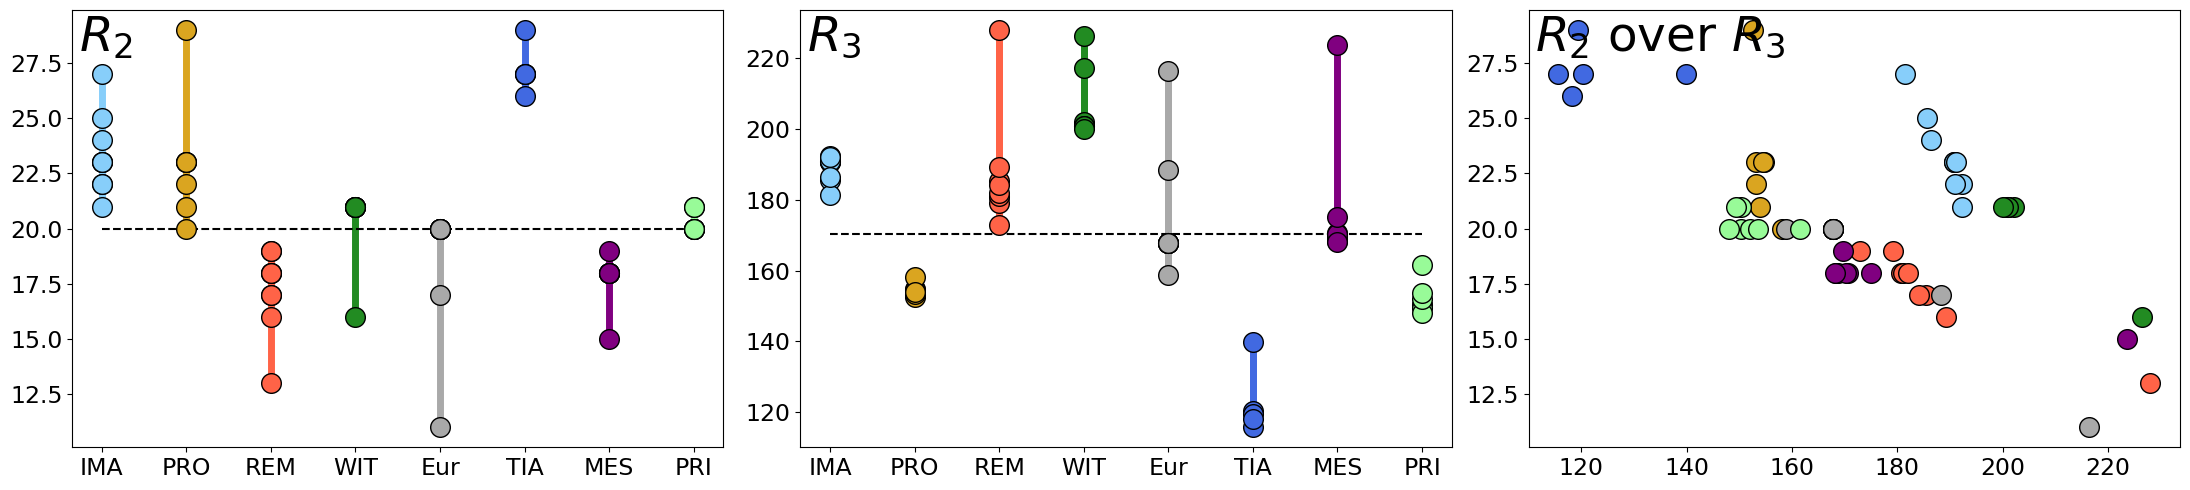

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), facecolor='white')
for m_i, m in enumerate(list_of_models):
    if m == "IMAGE 3.2": lw = 5
    else: lw=5
    dat = ind_xr.sel(Indicator="R2_time", Model=m, Time=2050).Value
    mi = m[:3]
    ax1.plot([mi]*2, [dat.max(), dat.min()], c=list_of_colors[m_i], label=m, lw=lw)
    ax1.scatter([mi]*len(dat), dat, c=list_of_colors[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)
    dat2 = ind_xr.sel(Indicator="R3_speedmax", Model=m, Time=2050).Value
    dat = dat[dat2 != 0]
    dat2 = dat2[dat2 != 0]
    if np.nanstd(dat2) != 0:
        ax2.plot([mi]*len(dat2), dat2, c=list_of_colors[m_i], label=m, lw=lw)
        ax2.scatter([mi]*len(dat2), dat2, c=list_of_colors[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)
    ax3.scatter(dat2, dat, c=list_of_colors[m_i], s=200, lw=1, edgecolor='k', zorder=1e9, label=m)

mn = np.nanmedian(ind_xr.sel(Indicator="R2_time", Time=2050).Value)
st = np.std(ind_xr.sel(Indicator="R2_time", Time=2050).Value)
ax1.plot([m[:3] for m in list_of_models], [mn]*len(list_of_models), '--k')
mn = np.nanmedian(ind_xr.sel(Indicator="R3_speedmax", Time=2050).Value)
st = np.std(ind_xr.sel(Indicator="R3_speedmax", Time=2050).Value)
ax2.plot([m[:3] for m in list_of_models], [mn]*len(list_of_models), '--k')

for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.text(0.01, 0.99, [r'$R_2$', r'$R_3$', r'$R_2$ over $R_3$'][i], transform=ax.transAxes, fontsize=35, ha='left', va='top', zorder=1e9)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.tick_params(axis='both', which='minor', labelsize=17)

fig.tight_layout()
plt.savefig(settings['paths']['figures']+"Figure_SI_r2vsr3.png", dpi = 400, bbox_inches = "tight")

#### Plot on S1 vs S1s

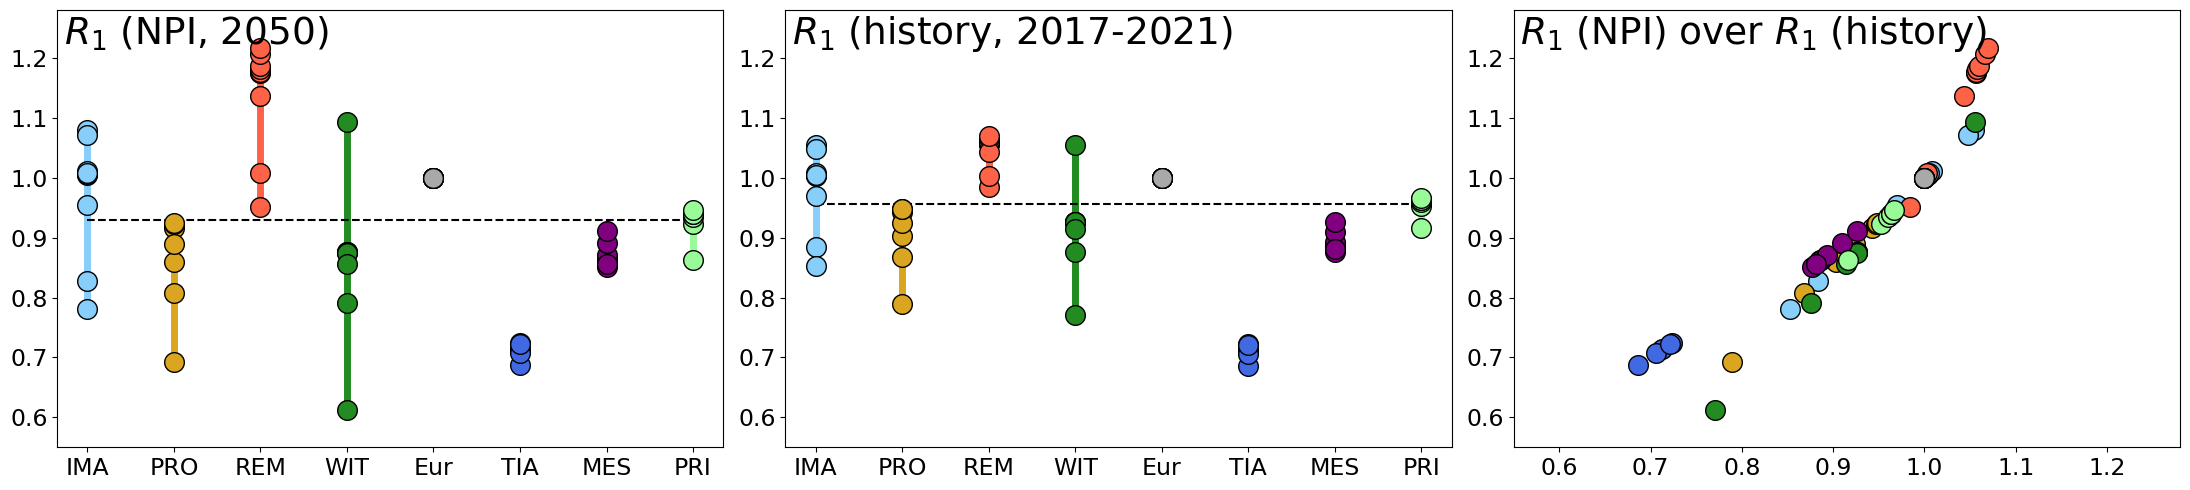

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5), facecolor='white')
for m_i, m in enumerate(list_of_models):
    if m == "IMAGE 3.2": lw = 5
    else: lw=5
    dat = ind_xr.sel(Indicator="R1_rai", Model=m, Time=2050).Value
    mi = m[:3]
    ax1.plot([mi]*2, [dat.max(), dat.min()], c=list_of_colors[m_i], label=m, lw=lw)
    ax1.scatter([mi]*len(dat), dat, c=list_of_colors[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)
    dat2 = ind_xr.sel(Indicator='R1s_rai', Model=m, Time=2050).Value
    dat = dat[dat2 != 0]
    dat2 = dat2[dat2 != 0]
    if np.nanstd(dat2) != 0:
        ax2.plot([mi]*len(dat2), dat2, c=list_of_colors[m_i], label=m, lw=lw)
        ax2.scatter([mi]*len(dat2), dat2, c=list_of_colors[m_i], s=200, lw=1, edgecolor='k', zorder=1e9)
    ax3.scatter(dat2, dat, c=list_of_colors[m_i], s=200, lw=1, edgecolor='k', zorder=1e9, label=m)

mn = np.nanmedian(ind_xr.sel(Indicator="R1_rai", Time=2050).Value)
st = np.std(ind_xr.sel(Indicator="R1_rai", Time=2050).Value)
ax1.plot([m[:3] for m in list_of_models], [mn]*len(list_of_models), '--k')
mn = np.nanmedian(ind_xr.sel(Indicator="R1s_rai", Time=2050).Value)
st = np.std(ind_xr.sel(Indicator="R1s_rai", Time=2050).Value)
ax2.plot([m[:3] for m in list_of_models], [mn]*len(list_of_models), '--k')

for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.text(0.01, 0.99, [r'$R_1$ (NPI, 2050)', r'$R_1$ (history, 2017-2021)', r'$R_1$ (NPI) over $R_1$ (history)'][i], transform=ax.transAxes, fontsize=27, ha='left', va='top', zorder=1e9)
    ax.tick_params(axis='both', which='major', labelsize=17)
    ax.tick_params(axis='both', which='minor', labelsize=17)
    ax.set_ylim([0.55, 1.28])
ax3.set_xlim([0.55, 1.28])

fig.tight_layout()
plt.savefig(settings['paths']['figures']+"Figure_SI_r1vsr1.png", dpi = 400, bbox_inches = "tight")

#### Plot on NPI and baseline

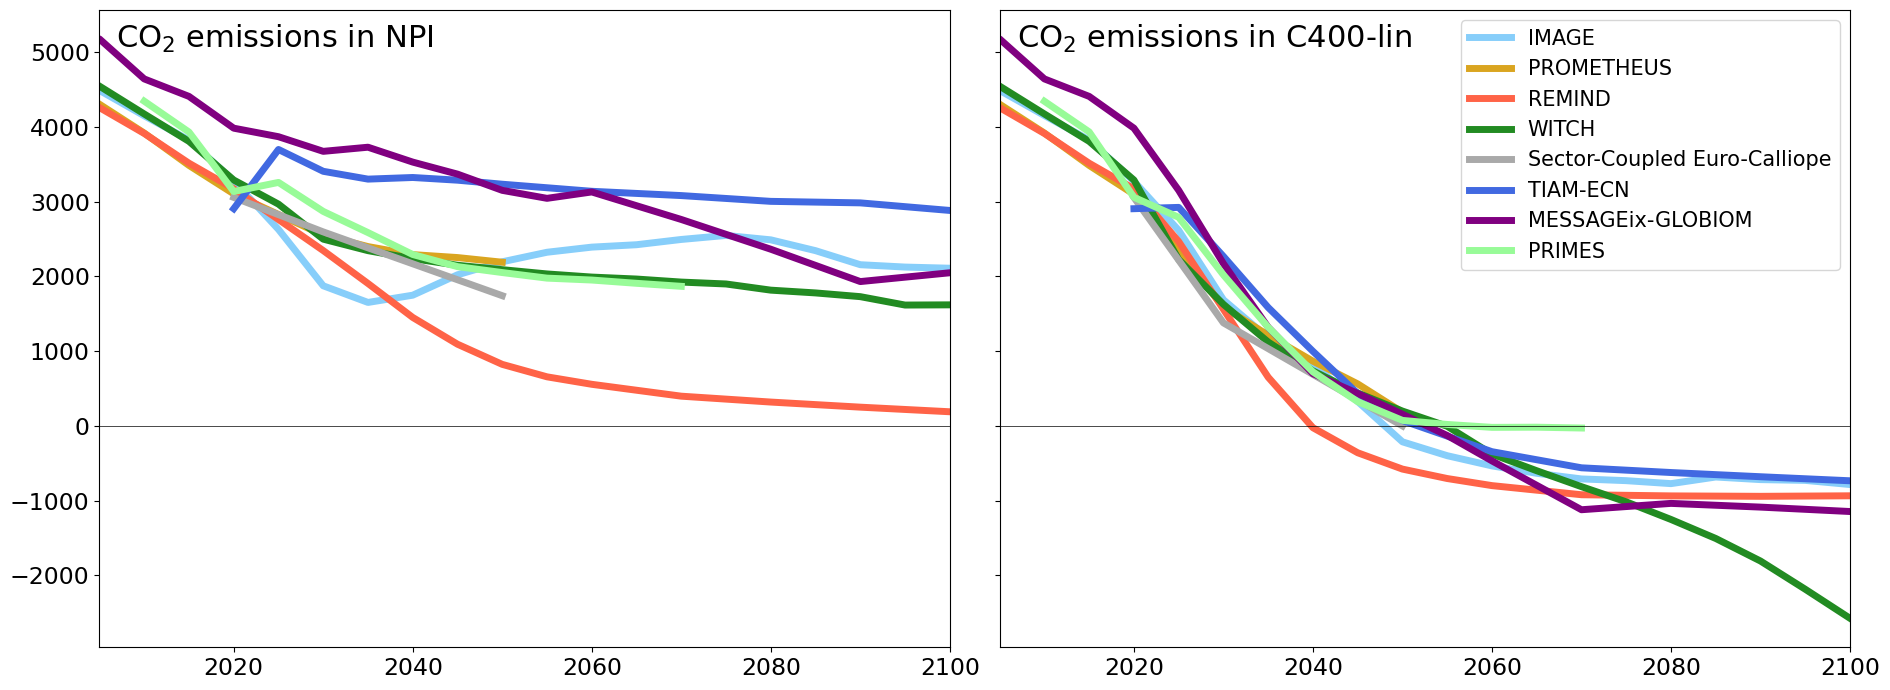

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 7), sharey=True, facecolor='white')
for m_i, m in enumerate(list_of_models):
    if m == "IMAGE 3.2": lw = 5
    else: lw=5
    y = ax1.plot(data_xr.Time,
                 xr.open_dataset(settings['paths']['data']['handling']+"XRdata.nc").sel(Region='Europe', Scenario="DIAG-NPI", Model=m, Variable="Emissions|CO2").Value,
                 c=list_of_colors[m_i], label=m.split(' ')[0], lw=lw)
    if m == "Euro-Calliope 2.0":
        mod = "Sector-Coupled Euro-Calliope"
        ax2.plot(data_xr.Time,
                 data_xr.sel(Scenario="DIAG-C400-lin", Model=m, Variable="Emissions|CO2").Value,
                 c=list_of_colors[m_i], label=mod, lw=lw)
    else:
        #ax1.plot(XRe.Time, XRe.sel(Scenario="DIAG-Base", Model=m, Variable="Emissions|CO2").Value, ':', c=y[0].get_color(), label=m, lw=lw)
        ax2.plot(data_xr.Time,
                 data_xr.sel(Scenario="DIAG-C400-lin", Model=m, Variable="Emissions|CO2").Value, c=list_of_colors[m_i], label=m.split(' ')[0], lw=lw)
ax1.set_xlim([2005, 2100])
ax2.set_xlim([2005, 2100])
ax1.plot([-1e3, 1e4], [0, 0], 'k', lw=0.5)
ax2.plot([-1e3, 1e4], [0, 0], 'k', lw=0.5)
plt.legend(fontsize=15)
ax1.text(0.02, 0.98, r"CO$_2$ emissions in NPI", fontsize=22, transform=ax1.transAxes, va='top')
ax2.text(0.02, 0.98, r"CO$_2$ emissions in C400-lin", fontsize=22, transform=ax2.transAxes, va='top')
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.tick_params(axis='both', which='minor', labelsize=17)
ax2.tick_params(axis='both', which='major', labelsize=17)
ax2.tick_params(axis='both', which='minor', labelsize=17)
fig.tight_layout()
plt.savefig(settings['paths']['figures']+"Figure_SI_baseornpi.png", dpi = 400, bbox_inches = "tight")

#### Plot with all histograms

In [107]:
names =[[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$"],
        [r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$"],
        [r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$"],
        [r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$"],
        [r"$C_1$", r"$C_2$", r"$C_3$"]]

namesf =[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$",
        r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$",
        r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$",
        r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$",
        r"$C_1$", r"$C_2$", r"$C_3$"]

vars = ["R1_rai", "R2_time", "R3_speedmax", "R4_sensprim", "R5_sensdem",
        "M1_cir", "M2_eir", "M3_cc", "M4_nonco2",
        "ES1_coal", "ES2_oil", "ES3_gas", "ES4_solar", "ES5_wind", "ES6_biomass", "ES7_nuclear",
        "ED1_etrans", "ED2_eindus", "ED3_ebuild", "ED4_emise", "ED5_hydrogen",
        "C1_cost", "C2_ti", "C3_dem"]

namesfull = ["Relative abatement index", "Time scale of initial mitigation", "Maximum mitigation speed", "Sensitivity primary energy mix", "Sensitivity demand",
"Carbon intensity reduction", "Energy intensity reduction", "Carbon capture", r"Role of non-CO$_2$"+"abatement",
"Coal", "Oil", "Gas", "Solar", "Wind", "Biomass", "Nuclear",
"Electricity transport", "Electricity industry", "Electricity buildings", "Electricity emissions", "Hydrogen use",
"Cumulative costs per abatement value", "Transformation index", "Demand shifts"]

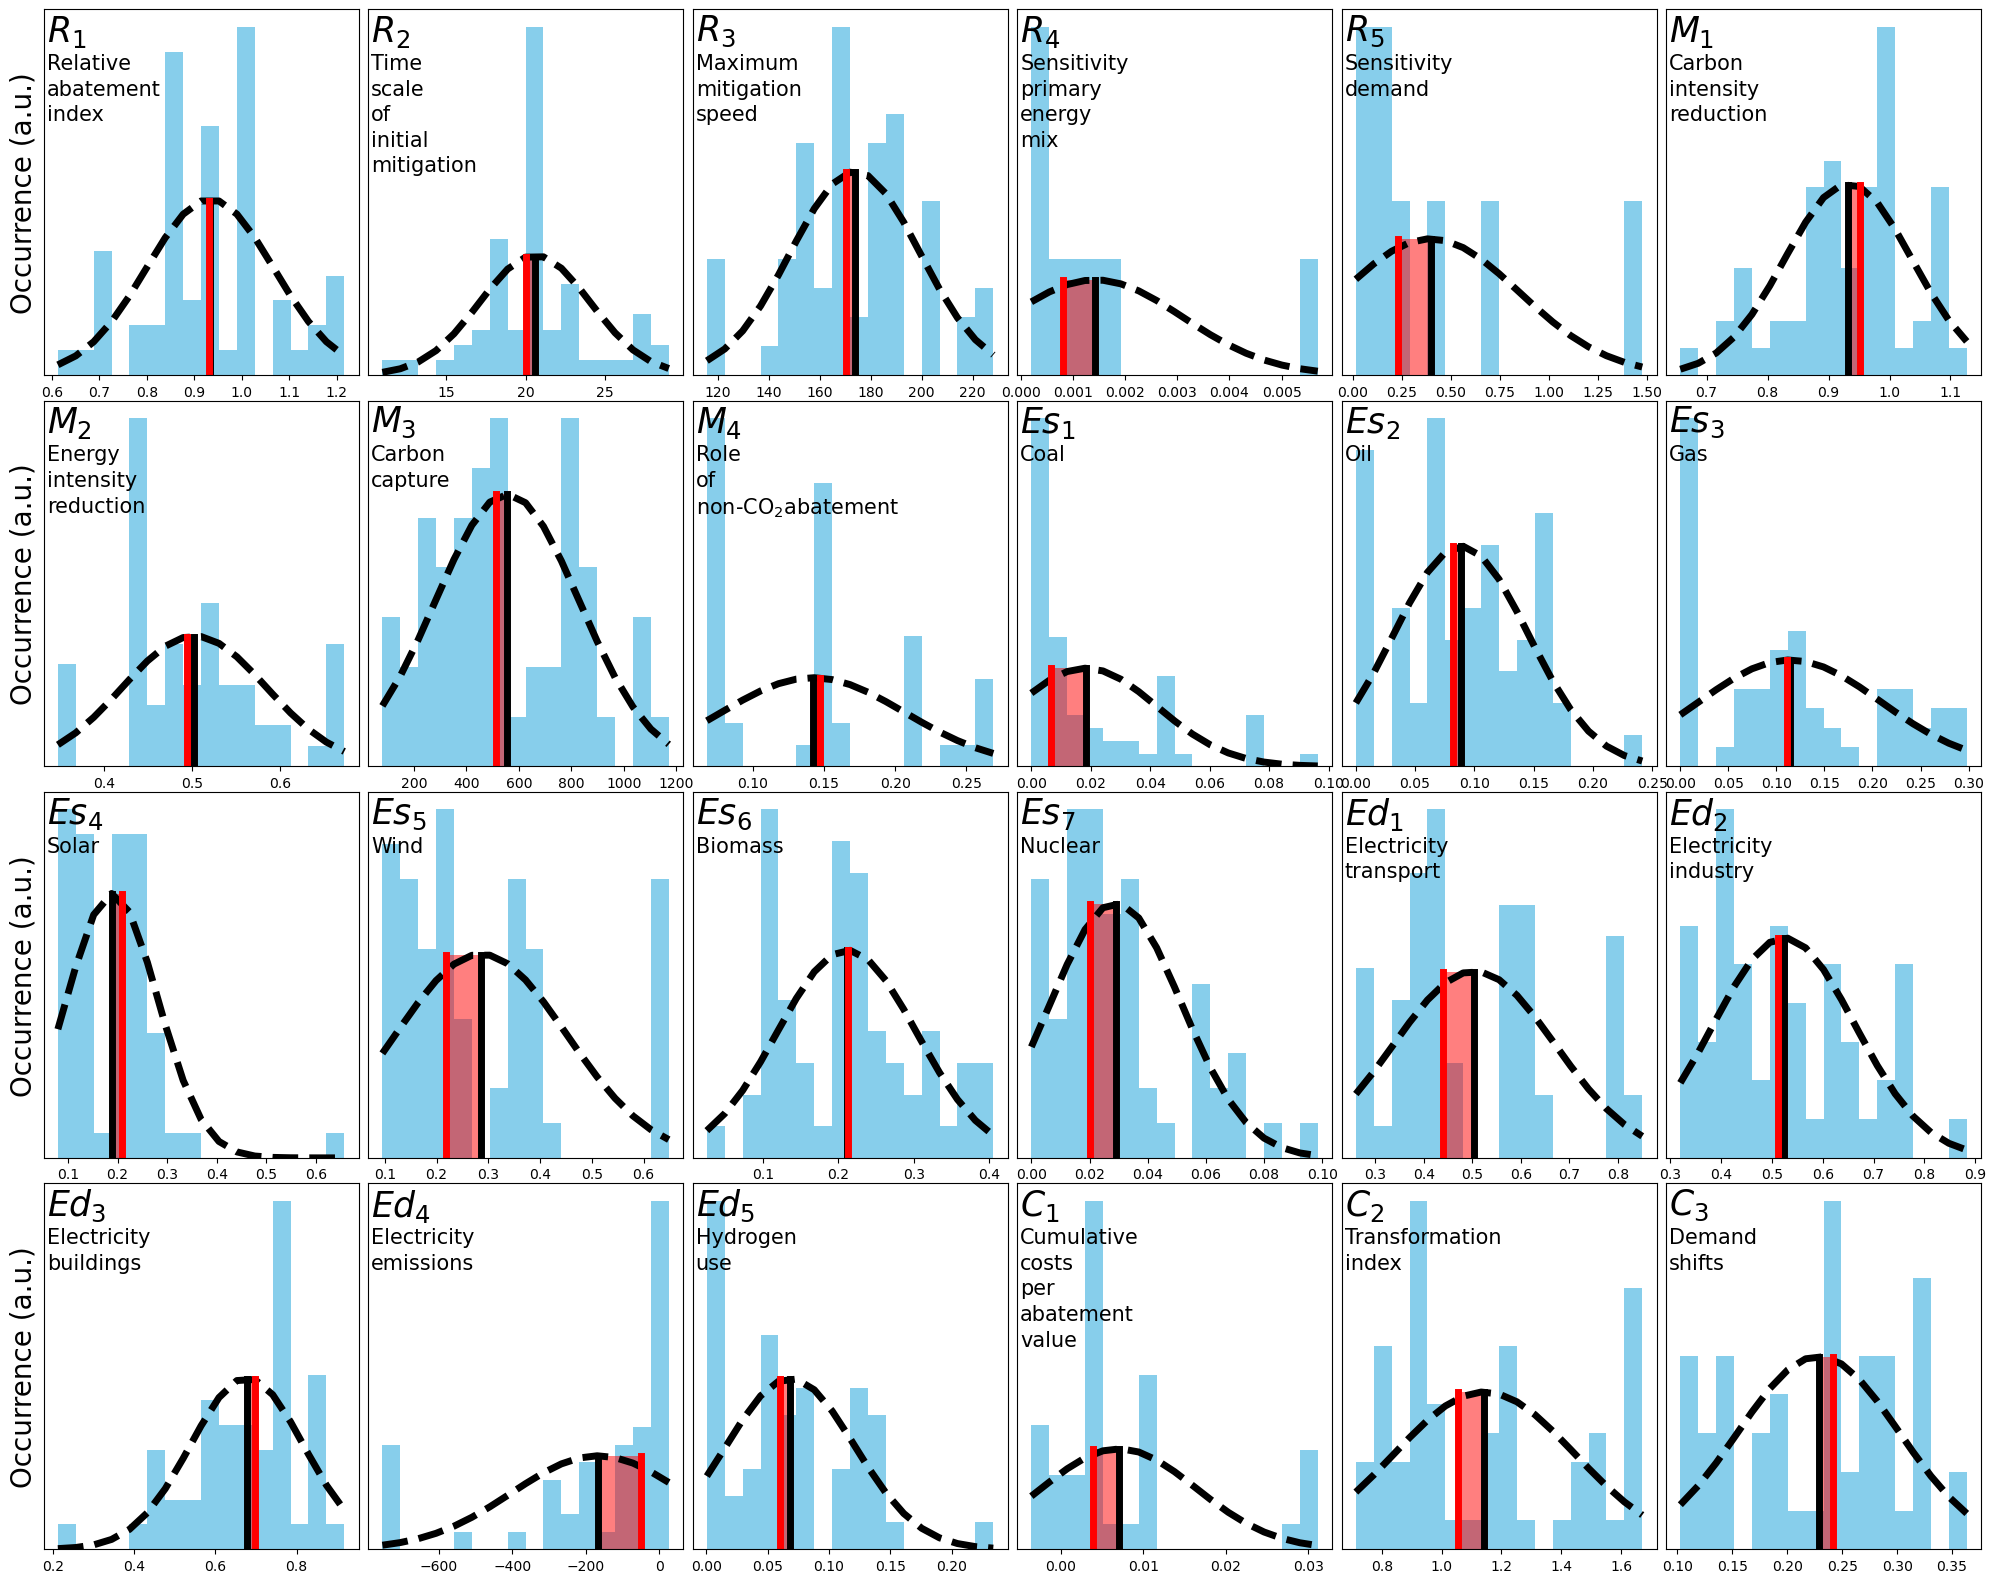

In [108]:
region = 'Europe'

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18), (ax19, ax20, ax21, ax22, ax23, ax24)) = plt.subplots(4, 6, figsize=(25, 20), facecolor='white')
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24]
ind_xr = xr.open_dataset(settings['paths']['data']['output']+"XRindicators.nc").sel(Scenario=settings['scenarios_c400'], Model=list_of_models, Region=region)


for i in range(24):
    ax = axes[i]
    data = np.array(ind_xr.sel(Indicator=vars[i], Time=2050).Value)
    #np.array(XRe.sel(Time=2050, Scenario=c400lins)[vars[i]]).flatten()
    data = data[~np.isnan(data)]
    (mu, sigma) = norm.fit(data)
    n, bins, patches = ax.hist(data, 16, lw=lw, facecolor='skyblue')
    ax.text(0.01, 0.99, namesf[i], transform=ax.transAxes, ha='left', va='top', fontsize=25)
    fullname = namesfull[i].split(' ')
    for f_i, f in enumerate(fullname):
        ax.text(0.01, 0.88-f_i*0.07, f, transform=ax.transAxes, ha='left', va='top', fontsize=15)
    
    y = norm.pdf( bins, mu, sigma)
    l = ax.plot(bins, y*len(data)/np.sum(y), 'k--', linewidth=5)
    ax.set_yticks([])
    ax.set_ylim(ax.get_ylim())
    mx = np.max(y*len(data)/np.sum(y))
    ax.plot([mu, mu], [-1e3, mx], 'k', linewidth=5)
    ax.plot([np.median(data), np.median(data)], [-1e3, mx], 'red', linewidth=5)
    x = [np.median(data), mu]
    y1 = np.array([0, 0])
    y2 = np.array([mx, mx])
    ax.fill_between(x, y1, y2, where=y2>=y1, facecolor='red', alpha=0.5)

for i in [0, 6, 12, 18]:
    ax = axes[i]
    ax.set_ylabel("Occurrence (a.u.)", fontsize=20)
fig.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig(settings['paths']['figures']+"Figure_SI_meanormedian_"+region+".png", dpi = 400, bbox_inches = "tight")